<a href="https://www.kaggle.com/code/deepakvk18/black-friday-sales-regression?scriptVersionId=102312809" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Problem Statement

A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

You can download the dataset from [here](https://datahack.analyticsvidhya.com/contest/black-friday/#ProblemStatement).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/black-friday-sales-prediction/train.csv
/kaggle/input/black-friday-sales-prediction/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, MultiLabelBinarizer
import category_encoders
from category_encoders import TargetEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline
plt.style.use('fivethirtyeight')

# Importing Dataset and Understanding the features

In [5]:
train_df = pd.read_csv('/kaggle/input/black-friday-sales-prediction/train.csv')
test_df = pd.read_csv('/kaggle/input/black-friday-sales-prediction/test.csv')

In [6]:
test = test_df.copy()

In [7]:
cat_train = train_df.copy()
cat_test=test_df.copy()

In [8]:
train_df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


**User_ID**    -> User ID

**Product_ID** -> Product ID

**Gender**     -> Sex of User

**Age**        -> Age in bins

**Occupation** -> Occupation (Masked)

**City_Category**  -> Category of the City (A,B,C)

**Stay_In_Current_City_Years**  -> Number of years stay in current city

**Marital_Status** -> Marital Status

**Product_Category_1** -> Product Category (Masked)

**Product_Category_2** -> Product may belongs to other category also (Masked)

**Product_Category_3** -> Product may belongs to other category also (Masked)

**Purchase**(Target)   -> Purchase Amount (Target Variable)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [10]:
train_df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [11]:
train_df.shape, test_df.shape

((550068, 12), (233599, 11))

# Filling in Missing Values

In [12]:
train_df.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [13]:
test_df.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64

I have to join all the category column as a single column as a list so that I can use MultiLabelBinarizer to OneHotEncode the columns.

In [14]:
def fillna(dataframe):
    dataframe.Product_Category_2.fillna(0, inplace=True)
    dataframe.Product_Category_3.fillna(0, inplace=True)

    dataframe['Product_Category'] = dataframe[['Product_Category_1','Product_Category_2','Product_Category_3']].values.tolist()
    dataframe.Age.replace({'0-17':0,'18-25':1,'26-35':2,'36-45':3,'46-50':4,'51-55':5,'55+':6}, inplace=True)
    dataframe.Stay_In_Current_City_Years.replace({'0':0,'1':1,'2':2,'3':3,'4+':4}, inplace=True)
    
    return dataframe

In [15]:
fillna(train_df).head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Product_Category
0,1000001,P00069042,F,0,10,A,2,0,3,0.0,0.0,8370,"[3.0, 0.0, 0.0]"
1,1000001,P00248942,F,0,10,A,2,0,1,6.0,14.0,15200,"[1.0, 6.0, 14.0]"
2,1000001,P00087842,F,0,10,A,2,0,12,0.0,0.0,1422,"[12.0, 0.0, 0.0]"
3,1000001,P00085442,F,0,10,A,2,0,12,14.0,0.0,1057,"[12.0, 14.0, 0.0]"
4,1000002,P00285442,M,6,16,C,4,0,8,0.0,0.0,7969,"[8.0, 0.0, 0.0]"


# Exploratory Data Analysis

In [16]:
eda_df = train_df.copy()

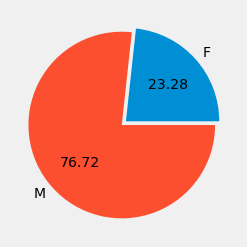

In [17]:
pie = eda_df.groupby('Gender').sum()
plt.pie(x=pie['Purchase'], labels= pie.index, explode=[0.03,0.03], autopct='%.2f');

Compared to the Males, Females have purchased for a lesser amount.

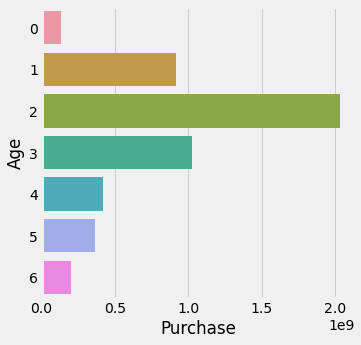

In [18]:
bar = eda_df.groupby('Age').sum()
plt.figure(figsize=(5,5))
sns.barplot(data=bar, x = 'Purchase', y=bar.index, orient='h');

People who are from age category of 26-35 years of age purchase the most.

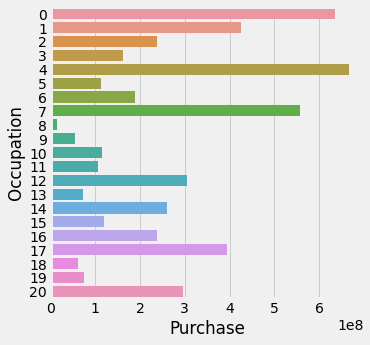

In [19]:
bar = eda_df.groupby('Occupation').sum()
plt.figure(figsize=(5,5))
sns.barplot(data=bar, x = 'Purchase', y=bar.index, orient='h');

People whose occupation is masked as 0,4 and 7 tend to purchase more when compared to other people.

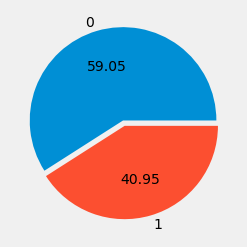

In [20]:
pie = eda_df.groupby('Marital_Status').sum()
plt.pie(x=pie['Purchase'], labels= pie.index, explode=[0.03,0.03], autopct='%.2f');

Unmarried people purchase more when compared to married people.

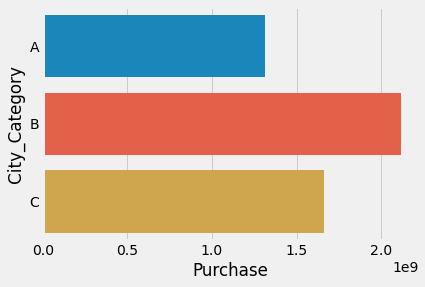

In [21]:
bar = eda_df.groupby('City_Category').sum()
#plt.figure(figsize=(5,5))
sns.barplot(data=bar, x = 'Purchase', y=bar.index, orient='h');

People from city Category B purchase the most.

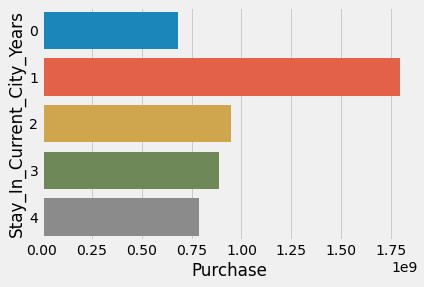

In [22]:
bar = eda_df.groupby('Stay_In_Current_City_Years').sum()
#plt.figure(figsize=(5,5))
sns.barplot(data=bar, x = 'Purchase', y=bar.index, orient='h');

People who are staying in the city for 1 year purchase for the maximum amount.

### Conclusions from Exploratory Data Analysis

* Compared to the Males, Females have purchased for a lesser amount.
* People whose occupation is masked as 0,4 and 7 tend to purchase more when compared to other people.
* Unmarried people purchase more when compared to married people.
* People from city Category B purchase the most.
* People who are staying in the city for 1 year purchase for the maximum amount.

# Encoding Categorical Variables

In [23]:
train_df=fillna(train_df)

In [24]:
numeric_cols = ['Marital_Status','Occupation','Stay_In_Current_City_Years','Age']
categoric_cols = ['City_Category','Gender']

mlb = MultiLabelBinarizer().fit(train_df['Product_Category'])

encoded_cols = list(mlb.fit(train_df['Product_Category']).classes_)
encoded = list(pd.get_dummies(fillna(train_df)[categoric_cols]).columns)


def encode_and_normalize(dataframe):
    dataframe = fillna(dataframe)
    dataframe[encoded_cols] = mlb.transform(dataframe['Product_Category'])
    dataframe[encoded] = pd.get_dummies(dataframe[categoric_cols])    
    
    return dataframe

In [25]:
encode_and_normalize(train_df).head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,...,16.0,17.0,18.0,19.0,20.0,City_Category_A,City_Category_B,City_Category_C,Gender_F,Gender_M
0,1000001,P00069042,F,0,10,A,2,0,3,0.0,...,0,0,0,0,0,1,0,0,1,0
1,1000001,P00248942,F,0,10,A,2,0,1,6.0,...,0,0,0,0,0,1,0,0,1,0
2,1000001,P00087842,F,0,10,A,2,0,12,0.0,...,0,0,0,0,0,1,0,0,1,0
3,1000001,P00085442,F,0,10,A,2,0,12,14.0,...,0,0,0,0,0,1,0,0,1,0
4,1000002,P00285442,M,6,16,C,4,0,8,0.0,...,0,0,0,0,0,0,0,1,0,1


# Training Machine Learning Models

### Splitting the data into train and test data

In [26]:
inputs = list(numeric_cols) + list(encoded_cols) + list(encoded)
inputs

['Marital_Status',
 'Occupation',
 'Stay_In_Current_City_Years',
 'Age',
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 'City_Category_A',
 'City_Category_B',
 'City_Category_C',
 'Gender_F',
 'Gender_M']

In [27]:
train_df = encode_and_normalize(train_df)

In [28]:
train_x, test_x, train_y, test_y = train_test_split(train_df[inputs],train_df['Purchase'],random_state=42, shuffle = True, test_size = 0.4)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((330040, 30), (220028, 30), (330040,), (220028,))

### 1. Decision Tree Model

In [29]:
dt = DecisionTreeRegressor(random_state=42, splitter='random')
dt.fit(train_x,train_y)
print(mean_squared_error(train_y, dt.predict(train_x), squared=False), 
mean_squared_error(test_y, dt.predict(test_x), squared=False)) #3289

2155.5395188894054 3397.7198595640903


### 2. Random Forest Model

In [30]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(train_x,train_y)
print(mean_squared_error(train_y, rf.predict(train_x), squared=False), 
                    mean_squared_error(test_y, rf.predict(test_x), squared=False)) #3048

2230.712983812236 3065.6945596748214


### 3. Ada Boost Model

In [31]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=42)
ada.fit(train_x,train_y)
print(mean_squared_error(train_y, ada.predict(train_x), squared=False), 
                    mean_squared_error(test_y, ada.predict(test_x), squared=False)) #3170

2395.089299918193 3094.2691699650136


### 4. CatBoost Regressor

In [32]:
cat_train.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [33]:
cat_inputs=['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3']
cat_target=['Purchase']

In [34]:
def cat_feature(dataframe):
    dataframe['Product_Category_2'] = dataframe['Product_Category_2'].fillna(0).astype('int')
    dataframe['Product_Category_3'] = dataframe['Product_Category_3'].fillna(0).astype('int')
    return dataframe

In [35]:
cat_features = [0,1,2,3,4,5,6,7,8,9,10]

In [36]:
cat_train = cat_feature(cat_train)

In [37]:
cat_trainx, cat_testx, cat_trainy, cat_testy = train_test_split(cat_train[cat_inputs],cat_train[cat_target], test_size=0.4)

In [38]:
cat = CatBoostRegressor(loss_function="RMSE")
cat.fit(cat_trainx, cat_trainy, cat_features=cat_features, eval_set=(cat_testx, cat_testy)) # 2543

Learning rate set to 0.126564
0:	learn: 4614.7363531	test: 4600.5434277	best: 4600.5434277 (0)	total: 637ms	remaining: 10m 36s
1:	learn: 4289.9116406	test: 4275.8380739	best: 4275.8380739 (1)	total: 838ms	remaining: 6m 58s
2:	learn: 4004.7544106	test: 3983.4746233	best: 3983.4746233 (2)	total: 1.21s	remaining: 6m 42s
3:	learn: 3763.5574513	test: 3737.2733633	best: 3737.2733633 (3)	total: 1.5s	remaining: 6m 12s
4:	learn: 3562.7820954	test: 3527.5338421	best: 3527.5338421 (4)	total: 1.84s	remaining: 6m 6s
5:	learn: 3400.0918987	test: 3358.6396114	best: 3358.6396114 (5)	total: 2.19s	remaining: 6m 3s
6:	learn: 3269.7783593	test: 3221.8408497	best: 3221.8408497 (6)	total: 2.41s	remaining: 5m 41s
7:	learn: 3160.5144925	test: 3109.0081193	best: 3109.0081193 (7)	total: 2.66s	remaining: 5m 30s
8:	learn: 3073.7864640	test: 3019.8397596	best: 3019.8397596 (8)	total: 2.9s	remaining: 5m 19s
9:	learn: 3001.2163921	test: 2945.2139851	best: 2945.2139851 (9)	total: 3.1s	remaining: 5m 7s
10:	learn: 2946

#### CatBoost Predictions

In [39]:
preds = cat.predict(cat_feature(cat_test)) #2543

Cat Boost Algorithm has byfar given the best RMSE out of all the other Algorithms.

# Submission

In [40]:
test_preds = encode_and_normalize(test_df)

In [41]:
test_preds.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,...,16.0,17.0,18.0,19.0,20.0,City_Category_A,City_Category_B,City_Category_C,Gender_F,Gender_M
0,1000004,P00128942,M,4,7,B,2,1,1,11.0,...,0,0,0,0,0,0,1,0,0,1
1,1000009,P00113442,M,2,17,C,0,0,3,5.0,...,0,0,0,0,0,0,0,1,0,1
2,1000010,P00288442,F,3,1,B,4,1,5,14.0,...,0,0,0,0,0,0,1,0,1,0
3,1000010,P00145342,F,3,1,B,4,1,4,9.0,...,0,0,0,0,0,0,1,0,1,0
4,1000011,P00053842,F,2,1,C,1,0,4,5.0,...,0,0,0,0,0,0,0,1,1,0


In [42]:
preds = rf.predict(test_preds[inputs])

In [43]:
preds = preds.flatten()

In [44]:
output = pd.DataFrame({'User_ID':test_df.User_ID,'Product_ID':test_df.Product_ID, 'Purchase':preds})
output.to_csv('submission.csv',index=False)

Best Model : AdaBoostRegressor